In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from mpl_toolkits import mplot3d

from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from patsy import dmatrices
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.discrete.discrete_model import Logit
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import itertools
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def diagnostic_plots(mod):
    sns.set_style('darkgrid')
    f, ax = plt.subplots(2,2, figsize=(12,10))
    
    smoothed = lowess(mod.resid, mod.fittedvalues)
    
    sns.scatterplot(x=mod.fittedvalues, y=mod.resid, ax=ax[0,0], alpha=0.5)
    ax[0,0].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[0,0].axhline(y=0, color='grey', ls='dashed', alpha=0.5)
    ax[0,0].set_xlabel('Fitted Values')
    ax[0,0].set_ylabel('Residuals')
    ax[0,0].set_title('Residuals vs Fitted')

    sm.qqplot(mod.resid, ax=ax[0,1], fit=True, line='45', alpha=0.5)
    ax[0,1].set_title('Normal Q-Q')
    
    student_residuals = mod.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = mod.resid.index
    smoothed = lowess(sqrt_student_residuals,mod.fittedvalues)
    
    sns.scatterplot(x=mod.fittedvalues, y=sqrt_student_residuals, ax=ax[1,0], alpha=0.5)
    ax[1,0].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[1,0].set_xlabel('Fitted values')
    ax[1,0].set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax[1,0].set_title('Scale-Location')
    
    smoothed = lowess(mod.get_influence().resid_studentized_internal, mod.get_influence().hat_matrix_diag)
    
    sns.scatterplot(x=mod.get_influence().hat_matrix_diag, y=mod.get_influence().resid_studentized_internal, ax=ax[1,1], alpha=0.5)
    ax[1,1].axhline(y=0, color='grey', linestyle='dashed', alpha=0.5)
    ax[1,1].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[1,1].set_xlabel('Leverage')
    ax[1,1].set_ylabel('Studentized Residuals')
    ax[1,1].set_title('Residuals vs Leverage')

In [3]:
def cfm(pred, y_true, class1='0', class2='1', error=False):
    ''' 
    Returns a Dataframe of the confusion matrix for a classification model given predictions and the true response values
    If error is passed as True, then it will also return the test error rate for the model 
    '''
    outside = ['Actual', 'Actual']
    inside = [class1, class2]
    outside2 = ['Prediction', 'Prediction']
    hier_index = list(zip(outside,inside))
    hier_col = list(zip(outside2, inside))
    hier_index = pd.MultiIndex.from_tuples(hier_index)
    hier_col = pd.MultiIndex.from_tuples(hier_col)
    if error == True:
        print(f' Test Error Rate: {np.mean(pred != y_true):.2%}')
    return pd.DataFrame(confusion_matrix(pred, y_true), index=hier_index, columns=hier_col)

## Chapter 6
### Lab
#### Best Subset Selection

In [4]:
hit = pd.read_csv('Hitters.csv')
hit.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
np.shape(hit)

(322, 20)

In [6]:
hit['Salary'].isnull().sum() # There are 59 missing values in the Salary column

59

In [7]:
hit.drop(hit[hit['Salary'].isnull()].index, inplace=True)

In [8]:
hit['Salary'].isnull().sum() 

0

In [9]:
np.shape(hit)

(263, 20)

I will be using the method for best subset selection that is outlined in this lab http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html

In [10]:
hit_dummies = pd.get_dummies(hit, drop_first=True)
y = hit['Salary']
X = hit.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X, hit_dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [11]:
def processSubset(feature_set):
    mod = sm.OLS(y, X[list(feature_set)])
    regr = mod.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y)**2).sum()
    return {'model':regr, 'RSS':RSS}

In [12]:
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print('Processed', models.shape[0],'models on', k, 'predictors in', (toc-tic), 'seconds')
    return best_model

In [13]:
models_best = pd.DataFrame(columns=['RSS', 'model'])
tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)
toc = time.time()
print('Total elapsed time:', (toc-tic), 'seconds.')

Processed 19 models on 1 predictors in 0.08267736434936523 seconds
Processed 171 models on 2 predictors in 0.33908700942993164 seconds
Processed 969 models on 3 predictors in 2.049464464187622 seconds
Processed 3876 models on 4 predictors in 8.213659286499023 seconds
Processed 11628 models on 5 predictors in 27.25680422782898 seconds
Processed 27132 models on 6 predictors in 76.90198230743408 seconds
Processed 50388 models on 7 predictors in 135.3689694404602 seconds
Total elapsed time: 258.0609793663025 seconds.


In [14]:
print(models_best.loc[2, 'model'].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Wed, 10 Mar 2021   Prob (F-statistic):                    5.80e-82
Time:                        15:59:40   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.006002187728881836 seconds
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Wed, 10 Mar 2021   Prob (F-statistic):                    1.31e-76
Time:                        15:59:40   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>

In [16]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [17]:
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

Text(0, 0.5, 'BIC')

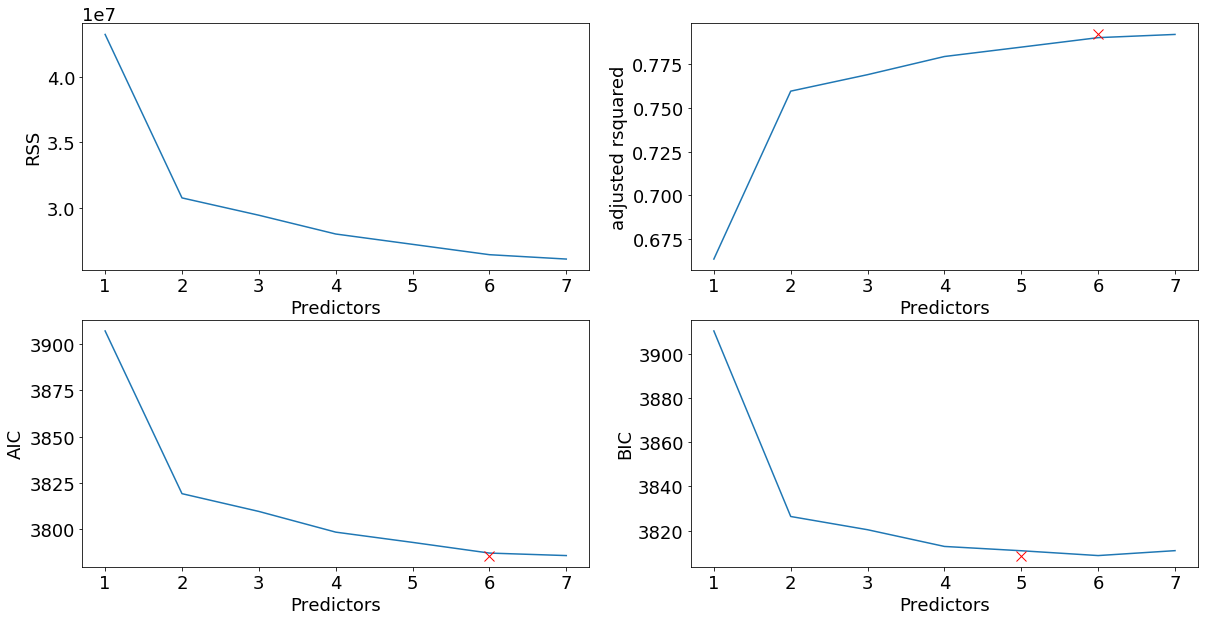

In [18]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
plt.subplot(2, 2, 1)

plt.plot(models_best["RSS"])
plt.xlabel('Predictors')
plt.ylabel('RSS')

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), 'rx')
plt.xlabel('Predictors')
plt.ylabel('adjusted rsquared')


aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), 'rx')
plt.xlabel('Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), 'rx')
plt.xlabel('Predictors')
plt.ylabel('BIC')

#### Forward and Backward Stepwise Selection

In [19]:
def forward(predictors):

    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    return best_model

In [20]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []
for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.04301047325134277 seconds.
Processed  18 models on 2 predictors in 0.04201865196228027 seconds.
Processed  17 models on 3 predictors in 0.04101872444152832 seconds.
Processed  16 models on 4 predictors in 0.04201865196228027 seconds.
Processed  15 models on 5 predictors in 0.03800010681152344 seconds.
Processed  14 models on 6 predictors in 0.03499889373779297 seconds.
Processed  13 models on 7 predictors in 0.03700137138366699 seconds.
Processed  12 models on 8 predictors in 0.03101515769958496 seconds.
Processed  11 models on 9 predictors in 0.02800607681274414 seconds.
Processed  10 models on 10 predictors in 0.02701544761657715 seconds.
Processed  9 models on 11 predictors in 0.027998685836791992 seconds.
Processed  8 models on 12 predictors in 0.02399587631225586 seconds.
Processed  7 models on 13 predictors in 0.0200042724609375 seconds.
Processed  6 models on 14 predictors in 0.01799607276916504 seconds.
Processed  5 models on 15 predict

In [21]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Wed, 10 Mar 2021   Prob (F-statistic):                    4.20e-64
Time:                        15:59:41   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Wed, 10 Mar 2021   Prob (F-statistic):                    1.79e-85
Time:                        15:59:41   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Backward Selection

In [23]:
def backward(predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    return best_model

In [24]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))
tic = time.time()
predictors = X.columns
while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.054012298583984375 seconds.
Processed  18 models on 17 predictors in 0.04902148246765137 seconds.
Processed  17 models on 16 predictors in 0.0480191707611084 seconds.
Processed  16 models on 15 predictors in 0.04400968551635742 seconds.
Processed  15 models on 14 predictors in 0.042017221450805664 seconds.
Processed  14 models on 13 predictors in 0.037999868392944336 seconds.
Processed  13 models on 12 predictors in 0.03500771522521973 seconds.
Processed  12 models on 11 predictors in 0.03000664710998535 seconds.
Processed  11 models on 10 predictors in 0.0299990177154541 seconds.
Processed  10 models on 9 predictors in 0.027005672454833984 seconds.
Processed  9 models on 8 predictors in 0.024016380310058594 seconds.
Processed  8 models on 7 predictors in 0.02100515365600586 seconds.
Processed  7 models on 6 predictors in 0.019006967544555664 seconds.
Processed  6 models on 5 predictors in 0.01500391960144043 seconds.
Processed  5 models on 4 

In [25]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [26]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [27]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64


#### Ridge Regression

In [29]:
hit = pd.read_csv('Hitters.csv')
hit.drop('Unnamed: 0', axis=1, inplace=True)
hit.drop(hit[hit['Salary'].isnull()].index, inplace=True)

In [31]:
hit_dummies = pd.get_dummies(hit, drop_first=True)
y = hit['Salary']
X = hit.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X, hit_dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)